# Variant Effect Prediction with OmniGenBench

This notebook demonstrates how to use various genomic foundation models for variant effect prediction. It processes genomic variants from a BED file, uses a reference genome, and predicts the functional effects of variants using deep learning models.


## Notebook Structure

This notebook is organized into several sections, each focusing on a specific aspect of the Variant Effect Prediction (VEP) pipeline. Below is an overview of the structure:

1. **Setup & Installation**: Ensures all required libraries and dependencies are installed.
2. **Import Libraries**: Loads the necessary Python libraries for genomic data processing, model inference, and analysis.
3. **Configuration**: Defines key parameters such as file paths, model selection, and batch sizes.
4. **Core Classes and Functions**: Implements essential utilities for handling genomic data, including downloading reference genomes, applying variants, and managing annotations.
5. **Model-Specific Embedding Functions**: Contains functions tailored to compute embeddings for different genomic foundation models.
6. **Main Analysis Pipeline**: Orchestrates the entire VEP process, from loading data to generating predictions and calculating scores.
7. **Execute the Analysis**: Runs the pipeline with the configured parameters and saves the results.
8. **Results Overview**: Summarizes the results and provides basic statistics.
9. **Visualization**: Visualizes the distribution of calculated distances to gain insights into the model's predictions.

Each section is designed to be modular, allowing for easy customization and extension. Follow the notebook sequentially to understand and execute the VEP pipeline effectively.

## 1. Setup & Installation

This cell contains the necessary packages for running the notebook. If you have already installed them, you can skip this step. Otherwise, uncomment and run the cell.

In [ ]:
# !pip install torch transformers pandas autocuda multimolecule biopython scipy scikit-learn tqdm dill findfile requests

## 2. Import Libraries

Import all the necessary libraries for genomic data processing, model inference, and analysis.

In [1]:
import os
import warnings
from typing import Optional, List, Tuple

import torch
import autocuda
import dill
import findfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy import spatial
from sklearn.metrics import roc_auc_score
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
from Bio import SeqIO

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

C:\Users\hengu\miniconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\hengu\miniconda3\envs\py312\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Libraries imported successfully!


## 3. Configuration

Set up the analysis parameters, file paths, and model selection here. You can easily change the `model_name` to test different genomic foundation models.

In [2]:
# --- Main Configuration ---
BED_FILE = "variant_effects_disease.bed"  # Path to your BED file with variants
FASTA_FILE = "data/genomes/GRCh38.primary_assembly.genome.fa"  # Path to reference genome
MODEL_NAME = "yangheng/OmniGenome-52M"  # Model to use for predictions
OUTPUT_FILE = "vep_predictions.csv"  # Base name for the output file
CONTEXT_SIZE = 256  # Context size (in base pairs) to include on each side of the variant
BATCH_SIZE = 16  # Batch size for model inference
DEVICE = "auto"  # Device: 'auto', 'cpu', 'cuda'

# --- Available Models for Testing ---
AVAILABLE_MODELS = [
    'yangheng/OmniGenome-52M',
    'yangheng/OmniGenome-186M',
    'DNABERT-2-117M',
    'hyenadna-large-1m-seqlen-hf',
    'InstaDeepAI/nucleotide-transformer-500m-human-ref',
    # 'multimolecule/rnafm', # RNA-specific models
    # 'multimolecule/rnabert',
    # 'lnair/SpliceBERT-510nt', # Splice-specific model
]

print(f"Configuration set:")
print(f"  Model: {MODEL_NAME}")
print(f"  BED file: {BED_FILE}")
print(f"  Reference genome: {FASTA_FILE}")

Configuration set:
  Model: yangheng/OmniGenome-52M
  BED file: variant_effects_disease.bed
  Reference genome: data/genomes/GRCh38.primary_assembly.genome.fa


## 4. Core Classes and Functions

This section contains the core logic for handling genomic data, including downloading the reference genome, applying variants, and managing annotations.

In [3]:
def download_ncbi_reference_genome():
    """Download and extract the hg38 reference genome if not found locally."""
    import requests
    import gzip
    import shutil

    # Check if a reference genome already exists
    found_genome = findfile.find_cwd_file(or_key=['hg38.fa', 'GRCh38.primary_assembly.genome.fa'], exclude_key=['.gz'])
    if found_genome:
        print(f"Reference genome already exists: {found_genome}")
        return found_genome

    url = "http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz"
    fasta_path_gz = "hg38.fa.gz"
    fasta_path = "hg38.fa"

    print(f"Downloading reference genome from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        with open(fasta_path_gz, 'wb') as f, tqdm(total=total_size, unit='B', unit_scale=True, desc=fasta_path_gz) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
    except requests.RequestException as e:
        raise Exception(f"Failed to download reference genome: {e}")

    print(f"Extracting {fasta_path_gz}...")
    with gzip.open(fasta_path_gz, 'rb') as f_in:
        with open(fasta_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    os.remove(fasta_path_gz)
    print(f"Reference genome ready at {fasta_path}")
    return fasta_path

class Annotation:
    """Handles loading variant annotations and extracting DNA sequences with context."""
    def __init__(self, annotation_path: str, reference_genome_path: str, context_size: int):
        self.context_size = context_size
        self.annotation = pd.read_csv(annotation_path, sep='\t')
        self.annotation['orig_start'] = self.annotation['start']
        self.annotation['orig_end'] = self.annotation['end']
        self.annotation['variant_offset'] = self.annotation['start'] - self.annotation['orig_start']
        
        print(f"Loading reference genome from {reference_genome_path}...")
        self.genome_dict = SeqIO.to_dict(SeqIO.parse(reference_genome_path, "fasta"))
        print(f"Loaded {len(self.genome_dict)} chromosomes.")
        
        self.extend_segments()

    def extend_segments(self):
        """Calculates new start/end coordinates to include the context window."""
        df = self.annotation
        df['start'] = (df['orig_start'] - self.context_size).clip(lower=0)
        df['end'] = df['orig_end'] + self.context_size
        df['mutation_position'] = (df['variant_offset'] + self.context_size).astype(int)
        self.annotation = df

    def get_dna_segment(self, index: int) -> str:
        """Extracts a DNA segment for a given variant index."""
        item = self.annotation.iloc[index]
        chrom = item.get('chromosome', item.get('chr'))
        start, end = int(item['start']), int(item['end'])
        
        if chrom not in self.genome_dict:
            # Try to match chromosome format (e.g., '1' vs 'chr1')
            chrom_alt = f"chr{chrom}" if not chrom.startswith('chr') else chrom.replace('chr', '')
            if chrom_alt in self.genome_dict:
                chrom = chrom_alt
            else:
                # print(f"Warning: Chromosome '{chrom}' not found in reference genome.")
                return ""
        
        seq_obj = self.genome_dict[chrom]
        end = min(end, len(seq_obj.seq))
        return str(seq_obj.seq[start:end]).upper()

def apply_variant(sequence: str, ref_allele: str, alt_allele: str, mut_pos: int) -> str:
    """Applies a single nucleotide variant (SNV) to a reference sequence."""
    if not (len(ref_allele) == 1 and len(alt_allele) == 1):
        return sequence # Only apply SNVs for this example
    
    if mut_pos < 0 or mut_pos >= len(sequence):
        # print(f"Warning: Mutation position {mut_pos} is out of bounds for sequence of length {len(sequence)}.")
        return sequence
        
    if sequence[mut_pos].upper() != ref_allele.upper():
        # print(f"Warning: Reference allele mismatch at position {mut_pos}. Expected {ref_allele}, found {sequence[mut_pos]}.")
        pass # Proceed with substitution anyway
        
    return sequence[:mut_pos] + alt_allele.upper() + sequence[mut_pos + 1:]

print("Core classes and functions defined.")

Core classes and functions defined.


## 5. Model-Specific Embedding Functions

This section defines the functions responsible for computing embeddings for different genomic foundation models. Each function is tailored to the specific tokenization and output structure of the model.

In [4]:
def _tokenize(batch_seqs: List[str], tokenizer, context_len: int, device: torch.device, add_spaces: bool = False):
    """Unified tokenization helper."""
    if add_spaces:
        batch_seqs = [' '.join(seq) for seq in batch_seqs]
    return tokenizer(
        batch_seqs,
        return_tensors="pt",
        padding="max_length",
        max_length=context_len,
        truncation=True,
        add_special_tokens=False
    ).to(device)

def _batch_extract_embeddings(batch_seqs, batch_pos, model, tokenizer, context_len, add_spaces=False):
    """Generic function to extract CLS and mutation position embeddings."""
    tokens = _tokenize(batch_seqs, tokenizer, context_len, model.device, add_spaces=add_spaces)
    with torch.no_grad():
        outputs = model(input_ids=tokens['input_ids'], output_hidden_states=True)
        hiddens = outputs.hidden_states[-1]  # Last hidden state

    cls_embs, mut_embs = [], []
    for j, pos in enumerate(batch_pos):
        cls_embs.append(hiddens[j, 0, :].cpu())  # [CLS] token embedding
        mut_embs.append(hiddens[j, pos, :].cpu()) # Mutation position embedding
    return cls_embs, mut_embs

def compute_batch_omnigenome_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size):
    cls_embs, mut_embs = [], []
    for i in tqdm(range(0, len(sequences), batch_size), desc="OmniGenome"):
        batch_seqs = sequences[i:i+batch_size]
        batch_pos = mut_positions[i:i+batch_size]
        c, m = _batch_extract_embeddings(batch_seqs, batch_pos, model, tokenizer, context_length, add_spaces=True)
        cls_embs.extend(c)
        mut_embs.extend(m)
    return cls_embs, mut_embs

def compute_batch_dnabert_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size):
    cls_embs, mut_embs = [], []
    for i in tqdm(range(0, len(sequences), batch_size), desc="DNABERT"):
        batch_seqs = sequences[i:i+batch_size]
        batch_pos = mut_positions[i:i+batch_size]
        c, m = _batch_extract_embeddings(batch_seqs, batch_pos, model, tokenizer, context_length, add_spaces=False)
        cls_embs.extend(c)
        mut_embs.extend(m)
    return cls_embs, mut_embs

def compute_batch_hyena_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size):
    cls_embs, mut_embs = [], []
    for i in tqdm(range(0, len(sequences), batch_size), desc="HyenaDNA"):
        batch_seqs = sequences[i:i+batch_size]
        batch_pos = mut_positions[i:i+batch_size]
        c, m = _batch_extract_embeddings(batch_seqs, batch_pos, model, tokenizer, context_length, add_spaces=False)
        cls_embs.extend(c)
        mut_embs.extend(m)
    return cls_embs, mut_embs

def compute_batch_nucleotide_transformer_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size):
    k = 6  # 6-mer tokenizer
    cls_embs, mut_embs = [], []
    for i in tqdm(range(0, len(sequences), batch_size), desc="Nucleotide Transformer"):
        batch_seqs = sequences[i:i+batch_size]
        batch_pos = mut_positions[i:i+batch_size]
        tok_pos = [p // k for p in batch_pos] # Map base position to token position
        c, m = _batch_extract_embeddings(batch_seqs, tok_pos, model, tokenizer, context_length // k, add_spaces=False)
        cls_embs.extend(c)
        mut_embs.extend(m)
    return cls_embs, mut_embs

def compute_batch_splice_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size):
    return compute_batch_dnabert_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size) # Uses same logic

def compute_batch_multimolecule_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size):
    return compute_batch_dnabert_outputs(sequences, mut_positions, context_length, model, tokenizer, batch_size) # Uses same logic

print("Model-specific functions defined.")

Model-specific functions defined.


## 6. Main Analysis Pipeline

This is the main function that orchestrates the entire variant effect prediction process. It loads data, generates sequences, computes embeddings, and calculates the final scores.

In [5]:
def run_vep_analysis(model_name, bed_file, fasta_file, context_size, batch_size, device):
    """Main pipeline for running the Variant Effect Prediction analysis."""
    
    # 1. Setup Device and Check Files
    print("--- Step 1: Initializing ---")
    if not os.path.exists(fasta_file):
        print(f"Reference genome not found. Attempting to download...")
        fasta_file = download_ncbi_reference_genome()
    if not os.path.exists(bed_file):
        raise FileNotFoundError(f"BED file not found at: {bed_file}")
    
    # 2. Load Genomic Annotation
    print("--- Step 2: Loading Annotations ---")
    genome_annotation = Annotation(bed_file, fasta_file, context_size)
    df = genome_annotation.annotation
    # Optional: uncomment to run on a small sample for quick testing
    # df = df.sample(n=100, random_state=42).reset_index(drop=True)
    print(f"Processing {len(df)} variants.")

    # 3. Load Model and Tokenizer
    print(f"--- Step 3: Loading Model: {model_name} ---")
    model_loader = AutoModelForMaskedLM if 'dnabert' in model_name.lower() or 'nucleotide-transformer' in model_name.lower() else AutoModel
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = model_loader.from_pretrained(model_name, trust_remote_code=True)
    if hasattr(model, 'base_model'): # For MaskedLM models
        model = model.base_model
    model.to(device).eval().half() # Use half precision
    print(f"Model loaded on {device} with {sum(p.numel() for p in model.parameters()):} parameters.")

    # 4. Select the correct embedding function
    model_name_lower = model_name.lower()
    if 'omnigenome' in model_name_lower: compute_func = compute_batch_omnigenome_outputs
    elif 'dnabert' in model_name_lower: compute_func = compute_batch_dnabert_outputs
    elif 'hyenadna' in model_name_lower: compute_func = compute_batch_hyena_outputs
    elif 'nucleotide-transformer' in model_name_lower: compute_func = compute_batch_nucleotide_transformer_outputs
    elif 'splice' in model_name_lower: compute_func = compute_batch_splice_outputs
    elif 'multimolecule' in model_name_lower: compute_func = compute_batch_multimolecule_outputs
    else: raise ValueError(f"No compute function found for model: {model_name}")

    # 5. Generate Reference and Alternative Sequences
    print("--- Step 4: Generating Sequences ---")
    seq_ref_list, seq_alt_list, mut_pos_list, valid_indices = [], [], [], []
    for idx, item in tqdm(df.iterrows(), total=len(df), desc="Generating Sequences"):
        seq_ref = genome_annotation.get_dna_segment(idx)
        if not seq_ref:
            continue
        mut_pos = int(item['mutation_position'])
        seq_alt = apply_variant(seq_ref, item['ref'], item['alt'], mut_pos)
        
        seq_ref_list.append(seq_ref)
        seq_alt_list.append(seq_alt)
        mut_pos_list.append(mut_pos)
        valid_indices.append(idx)

    # 6. Compute Embeddings
    print("--- Step 5: Computing Embeddings ---")
    context_length = context_size * 2
    r_cls, r_mut = compute_func(seq_ref_list, mut_pos_list, context_length, model, tokenizer, batch_size)
    a_cls, a_mut = compute_func(seq_alt_list, mut_pos_list, context_length, model, tokenizer, batch_size)

    # 7. Calculate Distances and Finalize Results
    print("--- Step 6: Calculating Scores ---")
    results = []
    def norm(x): return x / (torch.linalg.norm(x) + 1e-8)

    for i, original_idx in enumerate(valid_indices):
        cls_dist = spatial.distance.cosine(norm(a_cls[i]), norm(r_cls[i]))
        mut_dist = spatial.distance.cosine(norm(a_mut[i]), norm(r_mut[i]))
        row = df.loc[original_idx].to_dict()
        row.update({'cls_dist': cls_dist, 'mut_dist': mut_dist})
        results.append(row)

    results_df = pd.DataFrame(results)
    if 'label' in results_df.columns:
        overall_auc = roc_auc_score(results_df['label'], results_df['mut_dist'])
        print(f"Overall AUC based on 'mut_dist': {overall_auc:.4f}")
        results_df['overall_auc'] = overall_auc

    return results_df

print("Main analysis pipeline defined.")

Main analysis pipeline defined.


## 7. Execute the Analysis

This is the final step where we run the entire pipeline with the configured parameters. The results will be stored in a pandas DataFrame and saved to a CSV file.

In [6]:
# Setup device
compute_device = torch.device(autocuda.auto_cuda() if DEVICE == "auto" and torch.cuda.is_available() else DEVICE)

print(f"Starting analysis on device: {compute_device}")
print("=" * 50)

# Run the analysis
results_df = run_vep_analysis(
    model_name=MODEL_NAME, 
    bed_file=BED_FILE, 
    fasta_file=FASTA_FILE, 
    context_size=CONTEXT_SIZE, 
    batch_size=BATCH_SIZE, 
    device=compute_device
)

print("=" * 50)
print("Analysis completed!")

# Save results to CSV
output_filename = f"{MODEL_NAME.split('/')[-1]}_{OUTPUT_FILE}"
results_df.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")

Starting analysis on device: cuda:0
--- Step 1: Initializing ---
--- Step 2: Loading Annotations ---
Loading reference genome from data/genomes/GRCh38.primary_assembly.genome.fa...
Loaded 194 chromosomes.
Processing 295495 variants.
--- Step 3: Loading Model: yangheng/OmniGenome-52M ---


Some weights of OmniGenomeModel were not initialized from the model checkpoint at yangheng/OmniGenome-52M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda:0 with 52453345 parameters.
--- Step 4: Generating Sequences ---


Generating Sequences: 100%|██████████| 295495/295495 [00:34<00:00, 8571.48it/s]


--- Step 5: Computing Embeddings ---


OmniGenome: 100%|██████████| 18469/18469 [20:13<00:00, 15.22it/s]


--- Step 6: Calculating Scores ---
Overall AUC based on 'mut_dist': 0.5366
Analysis completed!
Results saved to: OmniGenome-52M_vep_predictions.csv


## 8. Results Overview

Let's take a look at the results. We'll display the first few rows of the output DataFrame and show some basic statistics about the calculated distances.

In [7]:
print("Results Summary:")
print(results_df[['chromosome', 'start', 'end', 'ref', 'alt', 'cls_dist', 'mut_dist']].describe())

print("\nFirst 5 results:")
display(results_df[['chromosome', 'start', 'end', 'ref', 'alt', 'cls_dist', 'mut_dist']].head())

Results Summary:
              start           end       cls_dist       mut_dist
count  2.954950e+05  2.954950e+05  295495.000000  295495.000000
mean   7.576644e+07  7.576695e+07       0.000874       0.360155
std    5.818433e+07  5.818433e+07       0.004454       0.226618
min    4.793900e+04  4.845100e+04       0.000000       0.000000
25%    3.162509e+07  3.162560e+07       0.000000       0.189546
50%    6.214818e+07  6.214869e+07       0.000488       0.293773
75%    1.107011e+08  1.107016e+08       0.000733       0.460186
max    2.474487e+08  2.474492e+08       0.510259       1.528320

First 5 results:


,chromosome,start,end,ref,alt,cls_dist,mut_dist
0,chr1,925768,926280,G,A,0.000977,0.151441
1,chr1,925769,926281,G,A,0.000000,0.309570
2,chr1,925770,926282,C,T,0.000244,0.161054
3,chr1,925772,926284,C,T,0.000000,0.283691
4,chr1,929879,930391,T,C,0.000000,0.175781


## 9. Visualization

Visualizing the distribution of the `cls_dist` and `mut_dist` scores can provide insights into how the model perceives the impact of variants.

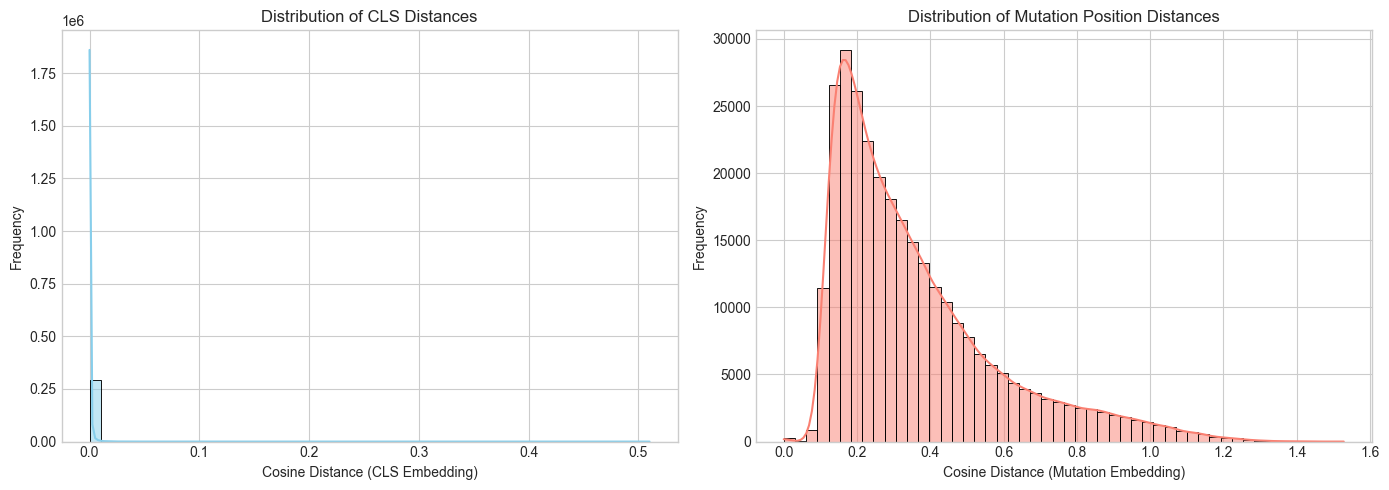

In [8]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.histplot(results_df['cls_dist'].dropna(), bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of CLS Distances')
    axes[0].set_xlabel('Cosine Distance (CLS Embedding)')
    axes[0].set_ylabel('Frequency')
    
    sns.histplot(results_df['mut_dist'].dropna(), bins=50, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Distribution of Mutation Position Distances')
    axes[1].set_xlabel('Cosine Distance (Mutation Embedding)')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

except ImportError:
    print("Matplotlib or Seaborn not found. Please install them to see visualizations: !pip install matplotlib seaborn")